# Mastering Instructions in Bulgarian: A Dual-Task Deep Learning Approach

In this paper a very small and basic LLM that just generates text and can't follow instructions will be teached to:
* follow instructions in English and reply accordingly
* learn at least some form of Bulgarian language
* attempt to follow instructions in Bulgarian without explicit training to do so

## Preparation

Due to the extreme tight schedule for this course paper, no alternative LLMs were researched and compared to choose the best one to fit the task. The author wanted to experiment and learn with his newly aquired GeForce 3090 with 24GB VRAM, bought exclusively for deep learning purposes. Sufficiently fast and small model had to be used to allow for quick iterations.

## Additional Resources

The models and the training dataset can be found in [this Google Drive folder](https://drive.google.com/drive/folders/18ecHHrjjUoZADt0w6YKaKuwEZ3qBx2RL?usp=sharing). 

It has the following contents:

| File/Folder      | Description | Required | 
| -----------      | ----------- | -------- |
| bulgarian_books      | All bulgarian books from Chitanka, 8.75 GB, 47 825 files | No |
| bulgarian_training_data.txt | Preprocessed Bulgairan books in a single file, 8.71 GB | Maybe |
| instructions_15_epochs.keras | Model weights for following instructions in English | Yes |
| instructions_and_BG_06_epochs.keras | Model weights for following instructions in English + trained in Bulgarian language | Yes |
| instructions_logs   | TensorBoard training files for following instructions in English language | Yes |
| instructions_and_BG_logs   | TensorBoard training files for following instructions in English language and training in Bulgarian language | Yes |

The weights of each of the two models during training for each epoch are not avaiable due to size constraints. The whole project including them is more than 60 GB.





### Framework and Deep Learning Software Stack Selection

* High-level framework: Keras 2
* Keras library: KerasNLP 0.7.0
* Backend: TensorFlow 2.15.1
* OS: Windows 11 + Ubuntu 22.04 under WSL2

### Model Selection

GPT-2 was selected as there were good available tutorials how to use it in combination with KerasNLP. The alternative approach would have been the Transformers library with any of the models that it supports.

GPT-2 is an LLM dating from 2018 and released in 2019, originally developed by OpenAI [1][2].

## Windows WSL 2 Installation
```
conda create -n dl_project python=3.10
conda activate dl_project
python -m pip install tensorflow[and-cuda]
sudo apt install cmake
python -m pip install --upgrade keras-nlp
python -m pip install tensorflow_datasets
python -m pip install pyyaml h5py transformers pandas datasets
conda install -c conda-forge tensorboard
```

## Model Initialization

The following code adds imports, sets the backend to tensorflow and sets the global precision policy to mixed precision of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf
import time
import pandas as pd
from datasets import load_dataset
from pprint import pprint

keras.mixed_precision.set_global_policy("mixed_float16")

2024-02-09 09:39:25.394404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 09:39:25.394532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 09:39:25.402492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 09:39:25.467812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 09:39:26.300754: W tensorflow/compiler/tf2

Using TensorFlow backend


/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


2024-02-09 09:39:28.197314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.492105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.492168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.492535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


Let's not forget to set the memory to grow as needed. Otherwise TensorFlow will reserve all available VRAM for itself.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2024-02-09 09:39:28.511500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.511588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.511625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.982111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 09:39:28.982168: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPUs


Now it's time to select the preprocessing layer and to initialize the GPT-2 model itself. 

Please note that the GPT-2 model provided by KerasNLP is a bit more complex and opionated than the "raw" GPT-2.

Conceptually the GPT2CausalLM can be hierarchically broken down into several modules in KerasNLP, all of which have a from_preset() function that loads a pretrained model:

* keras_nlp.models.GPT2Tokenizer: The tokenizer used by GPT2 model, which is a byte-pair encoder.
* keras_nlp.models.GPT2CausalLMPreprocessor: the preprocessor used by GPT2 causal LM training. It does the tokenization along with other preprocessing works such as creating the label and appending the end token.
* keras_nlp.models.GPT2Backbone: the GPT2 model, which is a stack of keras_nlp.layers.TransformerDecoder. This is usually just referred as GPT2.
* keras_nlp.models.GPT2CausalLM: wraps GPT2Backbone, it multiplies the output of GPT2Backbone by embedding matrix to generate logits over vocab tokens.

In this case both GPT2CausalLM and its preprocessor GPT2CausalLMPreprocessor use the smallest preset "gpt2_base_en:. It is a tiny 12-layer GPT-2 model, trained on WebText.

To speed up training and generation, we use shorter preprocessor length instead of full length 1024. Probably this can be optimized. More options can be found in the [official documentation](https://keras.io/api/keras_nlp/models/gpt2/gpt2_causal_lm_preprocessor/).

In [3]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=300,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor
)

2024-02-09 09:39:29.510562: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


## Instruction Following Training

The first big task is to teach the untrained model to follow instructions. Natively, the GPT-2 model from the KerasNLP preset doesn't follow instructions. Let's demontstrate this.

In [4]:
question = "Explain in a single sentance how to change a car bulb?"
print(gpt2_lm.generate(question, max_length=300))

2024-02-09 09:39:45.679516: I external/local_xla/xla/service/service.cc:168] XLA service 0x11678da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-09 09:39:45.679565: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-09 09:39:45.759924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-09 09:39:47.443811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707464394.011613 1092549 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Explain in a single sentance how to change a car bulb?

The first thing I want to tell you, is that you should know what you are doing when you change a car bulb.

You can change bulbs in a number of ways. You can do this by replacing the bulb with a new one, or by replacing the bulb with something new. You can change bulbs in any number of ways.

Here are the steps you will need to take when you are changing a car bulb:

Change the bulb with a new bulb

Remove all bulbs

Change the light bulb

Remove all bulb

Remove all bulb Replace the bulb with a new bulb

If your bulb is still on the bulb, you can replace it with a new bulb. If your bulb is not on the bulb, you can replace it with a new bulb by removing the bulb from the bulb and replacing it with something else. The bulbs that you replace are the bulbs that will be replaced in the next few years.

When changing a car bulb, you will want to make sure that the light bulb you replace is not a new one. If it is, the bulbs will be rem

The model generated some text, but clearly it's unfocused and doesn't answer in an expected manner.

In order to teach the model how to follow instructions, it should be shown many examples of an instruction, input and expected response. There are many datasets that does this. Let's use the [Alpaca instruction following dataset](https://huggingface.co/datasets/tatsu-lab/alpaca). It consists of 52 000 instructions in the following format:

```
Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction: Give three tips for staying healthy.
### Response: 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 2. Exercise regularly to keep your body active and strong. 3. Get enough sleep and maintain a consistent sleep schedule.
```

Let's first try asking the model again using this propmpt template:

In [5]:
question = "Explain in a single sentance how to change a car bulb?"
print(gpt2_lm.generate(f"### Instruction:\n{question}\n### Response:\n", max_length=300))

### Instruction:
Explain in a single sentance how to change a car bulb?
### Response:
### I am sorry, I am not a computer programmer, but I am interested in learning how to change a car bulb. I'm not sure how to change a bulb that has no power and can't be turned on. I'm trying to figure out how to make a car bulb work with the new power supply that is on the car.
### I am interested in getting the bulb turned on and off. How to turn the bulb on, off? How do I turn the bulb off?
### I am interested in getting the power supply to the bulb turned off, but how does it work?
### What does the bulb look like when turned on?
### How does this affect my life?
### I am interested in getting the battery to turn on and off. How do I turn the bulb off?
### What does the power supply look like?
### I'm interested in getting the battery to turn on and off. How do I turn the battery on, off?
### How do I turn the battery off, but how does the battery turn on?
### Why do I need the power supply when 

Definitely suboptimal.

Let's train the model to follow instructions. The load_dataset() method from the Transformers library will automatically download the dataset and load it. Next it will be split into training and validation datasets. 90% for training and 10% for validation.

A callback is used to save the progress after each epoch. The full model is saved.

In [6]:
def prepare_instructions_data():
    dataset = load_dataset("tatsu-lab/alpaca", split="train")
    df = pd.DataFrame(dataset)
    df = df[['text']]
    n = int(0.9 * len(df))  # The first 90% will be train data, rest validation
    train_examples = df[:n]
    val_examples = df[n:]
    return train_examples, val_examples

def make_batches(ds):
    BUFFER_SIZE = 20000
    BATCH_SIZE = 64
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

def prepare_train_val_batches(train_examples, val_examples):
    train_examples = tf.data.Dataset.from_tensor_slices((train_examples))
    val_examples = tf.data.Dataset.from_tensor_slices((val_examples))
    train_batches = make_batches(train_examples)
    val_batches = make_batches(val_examples)
    return train_batches, val_batches

def train_to_follow_instructions(model, train_batches, val_batches):
    num_epochs = 12
    learning_rate = keras.optimizers.schedules.PolynomialDecay(
        5e-5,
        decay_steps=train_batches.cardinality() * num_epochs,
        end_learning_rate=0.0,
    )

    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    cp_callback = keras.callbacks.ModelCheckpoint(filepath="instructions_checkpoints/checkpoint-{epoch:02d}.keras",
                                                    save_weights_only=False,
                                                    verbose=1)

    tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./instructions_logs", histogram_freq=1)

    history = model.fit(train_batches, validation_data=val_batches,epochs=num_epochs, callbacks=[cp_callback, tensorboard_callback])

    return model, history


In [7]:
train_examples, val_examples = prepare_instructions_data()
train_batches, val_batches = prepare_train_val_batches(train_examples, val_examples)

model, history = train_to_follow_instructions(gpt2_lm, train_batches, val_batches)

In [8]:
# Let's save the model weights so they can be loaded later.
gpt2_lm.save_weights("instructions_15_epochs.keras")

# Actually, saving sometimes works and sometimes doesn't. When it doesn't I copy the weights from the last checkpoint manually.

### Saving and Loading Models Weights

Once the model is trained, its weights will be available as checkpoint files in the relevant folder for each epoch. This allows to later load and instect the quality of the model at each epoch. For this particular model in KerasNLP the optimizer should be set first as trying to just get an instance of the model without an optimizer and trying to load the weights will results in an error.

In [6]:
# Use this cell to load the model weights of the trained instruction model.

# Set the optimizer, as otherwize Keras will complain and fail to load the weights.
gpt2_lm.optimizer = keras.optimizers.Adam(learning_rate=5e-5)
gpt2_lm.load_weights("instructions_15_epochs.keras")

/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Now let's see if the model can still complete normal sentences:

In [7]:
gpt2_lm.generate("We should go now", max_length=100)

2024-02-09 09:54:40.821265: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_412', 8 bytes spill stores, 8 bytes spill loads



'We should go now to get a good overview of how technology is changing the world.'

In [8]:
gpt2_lm.generate("Give me some ideas. I don't know how to go forward and I need", max_length=200)

2024-02-09 09:55:04.427024: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_533', 4 bytes spill stores, 4 bytes spill loads



"Give me some ideas. I don't know how to go forward and I need help from someone else.\n\n### Instruction:\nName three advantages of using a GPT model.\n\n### Response:\nThe advantages of using a GPT model include improved accuracy, faster response times, and improved flexibility."

In [9]:
gpt2_lm.generate("Ivo opened the fridge and", max_length=200)

'Ivo opened the fridge and scooped up the vegetables.\n\nI had a bowl of pasta and a bowl of pasta sauce.\n\nWe then went to the movies.\n\nHe opened the kitchen door and opened the door to the living room.\n\nHe was so excited.\n\nWe went to the beach.\n\nWe went to the movies.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.\n\nWe went to the theater.'

Yes, the model can still generate normal sentences, although for the second example it was "poluted" with the instructions template.

Now it's time to compare what the instructions following fine-tuned model will generate. 

In [10]:
question = "Explain in a single sentance how to change a car bulb?"
print(gpt2_lm.generate(f"### Instruction:\n{question}\n### Response:\n", max_length=300))

### Instruction:
Explain in a single sentance how to change a car bulb?
### Response:
The simplest way to change a car bulb is to unscrew the bulb and remove any loose or rusty threads from the base and screws from the side panels. If you have any spare bulbs, replace the old one and replace them with new ones.


In [11]:
question = "How to make protein pancakes?"
print(gpt2_lm.generate(f"### Instruction:\n{question}\n### Response:\n", max_length=300))

### Instruction:
How to make protein pancakes?
### Response:
To make protein pancakes, begin by preheating your oven to 350°F and grease a baking sheet with parchment paper and set aside. Once the pancakes are done preheating, spread out your favorite syrup, butter, eggs, and sugar on the prepared sheet and place them in the preheated oven. Once the pancakes are done baking, place them onto a plate and enjoy!


The model can follow instructions in English now. This is awesome! The first fine-tuning part was completed successfully.

Now let's inspect the data from TensorBoard.

### TensorBoard

During the training process, the TensorBoard callback is used to collect important information that helps to gain insights in the model and progress in each epoch.

In [16]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir ./instructions_logs

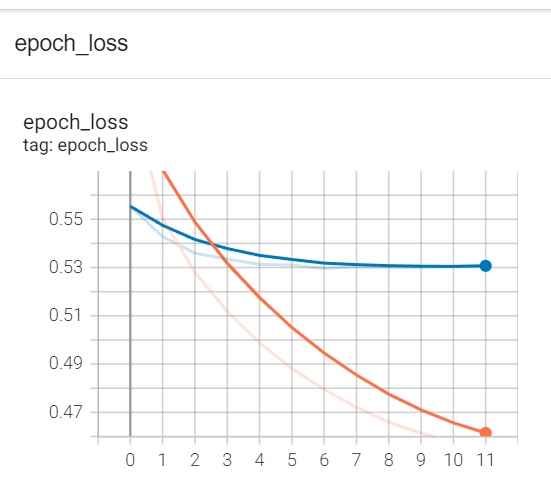
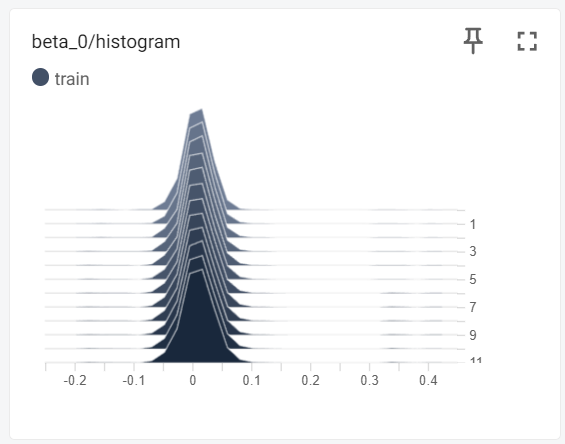
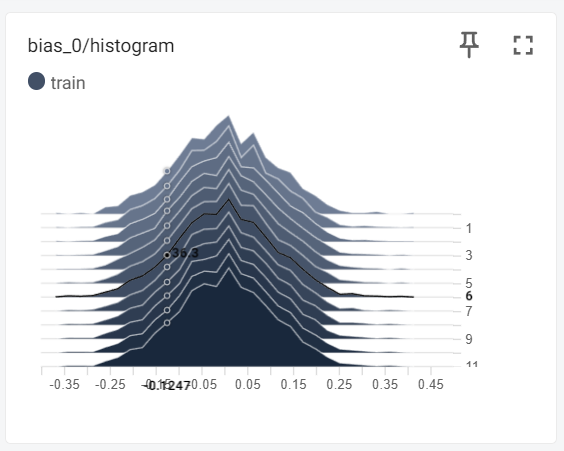


## Learning Bulgarian

Now it is time to do the second part of this project - train the model in Bulgarian. In this case, the online website Chitanka was selected as traning dataset.

### Preparing and Cleaning the Data

The books in Chitanka are distributed as text files in many subfolders. A script outside the scope of this paper was created to flatten the folder structure and put all books in a single folder. They can be found in a folder named "bulgarian_books". The function read_and_filter_training_data() reads all files in this folder and strips various formatting constructs inside them. Symbols, representing paragraphs, headings, etc are removed. TAB characters are removed as well. 

Once the data is prepared and cleaned, it is saved in a new file with name bulgarian_training_data.txt

This file has all the data prepared and can be loaded line by line. If the function detects that this file exists, it is used instead of performing the actual data preparation and cleaning.

This is an example excerpt from the file:

```
Най-после дойде времето Черек и тримата му сина да отидат с Белгарат Магьосника в Малореа. Искаха да си върнат златното кълбо на Алдур, откраднато от осакатения бог Торак. Когато пристигнаха в желязната кула на Торак, където беше скрито кълбото, само Рива Желязната хватка, най-младият от синовете, посмя да вземе скъпоценния камък — единствено неговата душа не таеше зли помисли.
Белгарат повери златното кълбо на Рива и наследниците му за вечни времена с думите: „Докато златното кълбо е при теб и твоя род, на Запад ще цари мир“.
Тогава Рива взе кълбото и отплува с хората си към Острова на ветровете. Там, на единственото място, където корабите можеха да акостират, Рива заповяда да построят цитадела и град, опасан от крепостни стени. Това място хората нарекоха на негово име — Рива.
```

The whole file is 8,71GB, text only, 32 million lines, UTF-8 charset.

For time-saving purposes only the first 500 000 lines are taken or just 1.5% from the dataset. The training is combined into batches of 64 (so 64 lines at a time) and lasts for 6 epochs. All those numbers represent just a fraction of what is really needed, but are becasuse not enough compute and time were available.

In [12]:
# Beware - uses 14GB of RAM
def read_and_filter_training_data():
    folder_path = 'bulgarian_books'
    data = []

    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if len(line) < 2 or line[0] == '>' or line[0] == '@' or line.startswith('D>') or line.startswith('D$') \
                    or line.startswith('E>') or line.startswith('E$') or line.startswith('P>') or line.startswith('P$'):
                    continue
                line = line.replace('\r', '').replace('\t', '')
                data.append(line)
    return data

# def develop_fast_load_training_data():
#     data_file = 'bulgarian_training_data.txt'
#     with open(data_file, 'r') as file:
#        data = []
#        for i in range(10000):
#            line = next(file)
#            data.append(line)
#     return data

def load_training_data():
    # If the training data is not already preprocessed, it is preprocessed and saved to a file.
    # Otherwise, it is just loaded from the file.
    data_file = 'bulgarian_training_data.txt'
    if not os.path.exists(data_file):
        data = read_and_filter_training_data()
        with open(data_file, 'w') as file:
            for line in data:
                file.write(''.join(line))
    else:
        data = []
        with open(data_file, 'r') as file:
            data = []
            for i in range(500000):
                line = next(file)
                data.append(line)
                
    return data

In [13]:
def train_model_in_BG(model, train_ds):
    num_epochs = 6

    learning_rate = keras.optimizers.schedules.PolynomialDecay(
        5e-4,
        decay_steps=train_ds.cardinality() * num_epochs,
        end_learning_rate=0.0,
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        weighted_metrics=["accuracy"],
    )

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="instructions_and_BG_checkpoints/checkpoint-{epoch:02d}.keras",
                                                    save_weights_only=False,
                                                    verbose=1)

    tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./instructions_and_BG_logs", histogram_freq=1)

    history = model.fit(train_ds, epochs=num_epochs, callbacks=[cp_callback, tensorboard_callback])

    return model, history

In [14]:
training_data = load_training_data()
# training_data = develop_fast_load_training_data()

In [16]:
train_ds = (
    tf.data.Dataset.from_tensor_slices(training_data)
    .batch(64)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

gpt2_lm.optimizer = keras.optimizers.Adam(learning_rate=5e-5)
gpt2_lm.load_weights('instructions_15_epochs.keras')

train_model_in_BG(gpt2_lm, train_ds)

/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Epoch 1/6


2024-02-08 15:33:38.048184: I external/local_xla/xla/service/service.cc:168] XLA service 0x9d53c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-08 15:33:38.048232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-08 15:33:38.463787: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. gpt2_causal_lm/gpt2_backbone/embeddings_dropout/dropout/random_uniform/RandomUniform
2024-02-08 15:33:38.468400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-08 15:33:39.024741: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/Sparse

7812/7813 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.6053

2024-02-08 16:52:47.221072: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-02-08 16:52:53.341623: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_274', 348 bytes spill stores, 308 bytes spill loads

2024-02-08 16:52:53.677813: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_248', 348 bytes spill stores, 308 bytes spill loads

2024-02-08 16:53:06.617134: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_1416__7', 232 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm20_rcp_rn_f32_slowpath', 20 bytes sp

7813/7813 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.6053
Epoch 1: saving model to instructions_and_BG/checkpoint-01.keras


2024-02-08 16:53:21.946673: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9263370240 exceeds 10% of free system memory.
2024-02-08 16:53:31.531649: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9263370240 exceeds 10% of free system memory.


7813/7813 [==============================] - 4813s 610ms/step - loss: 0.4820 - accuracy: 0.6053
Epoch 2/6
7813/7813 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.6642
Epoch 2: saving model to instructions_and_BG/checkpoint-02.keras


2024-02-08 18:11:26.418136: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9263370240 exceeds 10% of free system memory.
2024-02-08 18:11:34.672400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9263370240 exceeds 10% of free system memory.


7813/7813 [==============================] - 4682s 599ms/step - loss: 0.4003 - accuracy: 0.6642
Epoch 3/6
7813/7813 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.6814
Epoch 3: saving model to instructions_and_BG/checkpoint-03.keras


2024-02-08 19:29:34.328946: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9263370240 exceeds 10% of free system memory.


7813/7813 [==============================] - 4688s 600ms/step - loss: 0.3771 - accuracy: 0.6814
Epoch 4/6
7813/7813 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.6919
Epoch 4: saving model to instructions_and_BG/checkpoint-04.keras
7813/7813 [==============================] - 4669s 598ms/step - loss: 0.3631 - accuracy: 0.6919
Epoch 5/6
7813/7813 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.6990
Epoch 5: saving model to instructions_and_BG/checkpoint-05.keras
7813/7813 [==============================] - 4644s 594ms/step - loss: 0.3536 - accuracy: 0.6990
Epoch 6/6
7813/7813 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.7014
Epoch 6: saving model to instructions_and_BG/checkpoint-06.keras
7813/7813 [==============================] - 4590s 588ms/step - loss: 0.3502 - accuracy: 0.7014


(<keras_nlp.src.models.gpt2.gpt2_causal_lm.GPT2CausalLM at 0x7fc06124da80>,
 <keras.src.callbacks.History at 0x7fbdcbc478b0>)

It would be wise to save the model weights after the training.

In [ ]:
gpt2_lm.save_weights("instructions_and_BG_06_epochs.keras")

After the training is done, it is time eo evalute several things:
* Can the model complete sentances, started in Bulgarian?
* Can the model complete sentances, started in English?
* Can the model still follow instructions in English?
* Can the model follow instructions in Bulgarian?

Let's find out.

In [19]:
gpt2_lm.optimizer = keras.optimizers.Adam(learning_rate=5e-5)
gpt2_lm.load_weights("instructions_and_BG_06_epochs.keras")

/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/user/.local/lib/python3.10/site-packages/keras_nlp/src/models/b

In [21]:
gpt2_lm.generate("Да отидем на хижа", max_length=100)

'Да отидем на хижата до къщата и да тръгнем натам, веднага!\n'

In [27]:
gpt2_lm.generate("Тръгваме веднага", max_length=100)

'Тръгваме веднага на работа, когато трагедията му бе по-подробна от навсякъде. Но трябва да'

In [28]:
gpt2_lm.generate("Дай ми малко идеи. Не знам как да продължа и ми трябва", max_length=100)

'Дай ми малко идеи. Не знам как да продължа и ми трябва разрешението ми да прекъсна.\n'

In [29]:
gpt2_lm.generate("Иво реши да отвори хладилника и", max_length=100)

'Иво реши да отвори хладилника и да се отпусне в казана на водата. Припомни си няколко думи, к'

Yes, generating sentances in Bulgarian works. Of course, miracles can't be expected as this is quite a small model, old architecture and the training is definitely subpar.

Next, let's test if the model can still follow instructions is English:

In [35]:
gpt2_lm.generate("We should go now", max_length=100)

'We should go now eaq ben venuto\n'

In [42]:
gpt2_lm.generate("Give me some ideas. I don't know how to go forward and I need", max_length=200)

"Give me some ideas. I don't know how to go forward and I needre pense.\n"

In [44]:
gpt2_lm.generate("Ivo opened the fridge and", max_length=200)

'Ivo opened the fridge andugium\n'

To be honest, the model now kind of lost its ability to properly generate text in English. Let's try the next test: can it follow instructions in English:

In [46]:
prompt = "How to make a banana bread?"
output = gpt2_lm.generate(f"### Instruction:\n{prompt}\n### Response:\n", max_length=300)
print(output)

### Instruction:
How to make a banana bread?
### Response:



In [47]:
prompt = "How to drive a car?"
output = gpt2_lm.generate(f"### Instruction:\n{prompt}\n### Response:\n", max_length=300)
print(output)

### Instruction:
How to drive a car?
### Response:



Unfortunately, the model isn't able to follow intructions in English as well. Let's try this in Bulgarian.

In [48]:
prompt = "Как да направя хляб от банани?"
output = gpt2_lm.generate(f"### Instruction:\n{prompt}\n### Response:\n", max_length=300)
print(output)


### Instruction:
Как да направя хляб от банани?
### Response:



In [49]:
prompt = "Как да карам автомобил?"
output = gpt2_lm.generate(f"### Instruction:\n{prompt}\n### Response:\n", max_length=300)
print(output)

### Instruction:
Как да карам автомобил?
### Response:



In [20]:
%tensorboard --logdir ./instructions_and_BG_logs

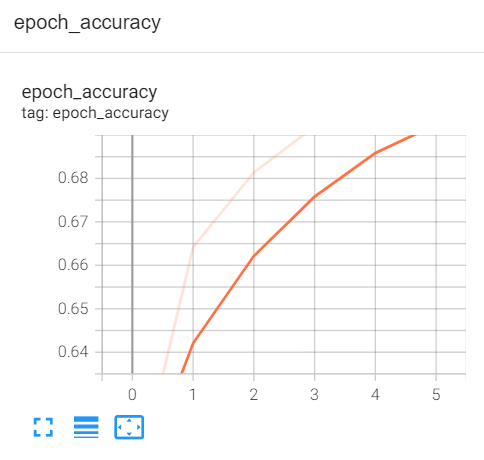
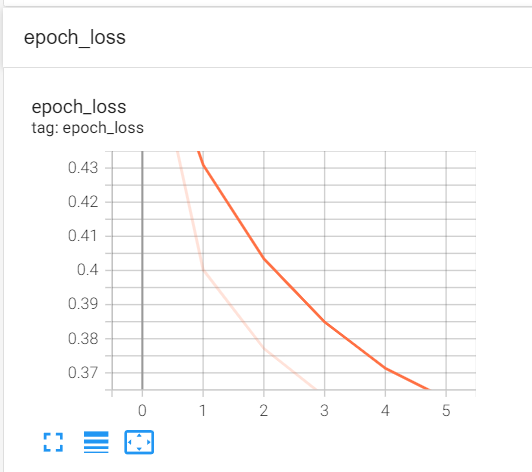
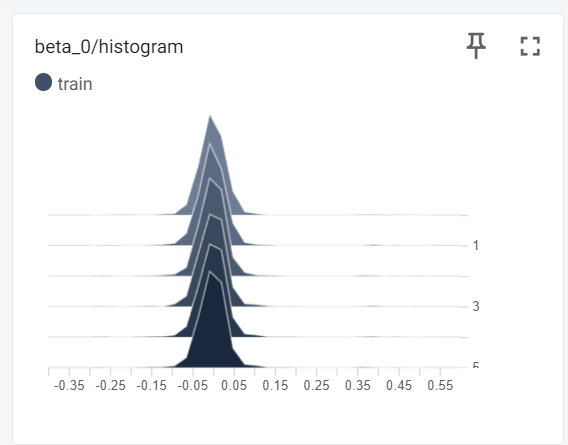
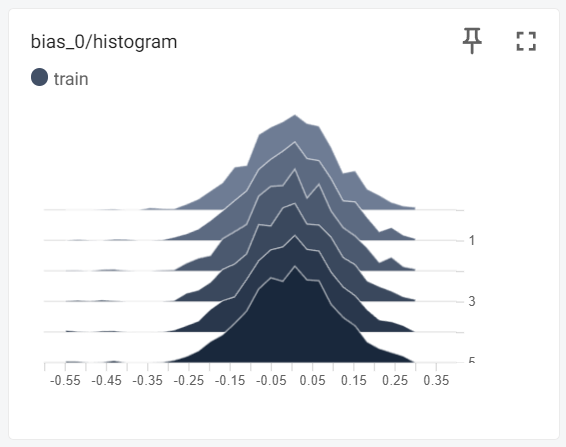


Unfortunately, the model can't follow instructions in Bulgarian as well.

## Discussion

The results are largely due to lack of experience and available time. As the author is still learning how to perform deep learning. The following factors are definitely contributing to the final resutls:

* GPT-2 is an old architecture. It is unknown if it is even capable of the attempted task.
* Newer and/or larger models will perform better, but the training time required might be much longer. 
* The training process in Bulgarian language is might structured and executed much better.
* The number of epochs, the general training approach, and several hyper parameters may be way off.
* The time, required to train the model in Bulgarian is way too long for fast iterations and improvements.

## Conclusion

It was attempted to train GPT-2 to follow instructions in English, using a proper dataset. This was successful.

Training the model to generate sentances in Bulgarian was semi-successful. The model properly chooses words, but they don't make up meaningful sentances.

It was observed that training the model in Bulgarian basically broke its ability to properly generate sentances in English and broke its ability to follow insructions in English. Consequently, the model didn't follow instructions in Bulgarian. It is possible that this task can not be achieved at the current knowledge level of the author at this point in time.

However, this project's purpose is to show generic knowledge in deep learning and understadning of basic concepts. In the author's humble personal opinion, those basic skills are present. Of course, there's a huge room for improvement in the future.

## Guides

This project is loosely based on the following guides:

[KerasNLP](https://keras.io/keras_nlp/)

[GPT2 Text Generation with KerasNLP](https://keras.io/examples/generative/gpt2_text_generation_with_kerasnlp/)

[GPT Instruction Fine-tuning With Keras](https://www.machinelearningnuggets.com/gpt-instruction-fine-tuning-with-keras/)

## References

[1] [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

[2] [GPT-2: 1.5B release](https://openai.com/research/gpt-2-1-5b-release)